In [1]:
import os
import json
from glob import glob
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D, Dropout, BatchNormalization, Flatten, MaxPool1D, GlobalAveragePooling1D, Multiply, LSTM
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
cd /gdrive

/gdrive


In [4]:
tf.random.set_seed(123)

### Load dataset

In [5]:
x_train_path = '/gdrive/MyDrive/dataset-460-40/x/'
y_train_path = '/gdrive/MyDrive/dataset-460-40/y/'
x_test_path = '/gdrive/MyDrive/dataset-460-40/x_test/'
y_test_path = '/gdrive/MyDrive/dataset-460-40/y_test/'

x_train_jsons = glob(x_train_path+'*.json')
y_train_jsons = glob(y_train_path+'*.json')
x_test_jsons = glob(x_test_path+'*.json')
y_test_jsons = glob(y_test_path+'*.json')

x_train_jsons.sort()
y_train_jsons.sort()
x_test_jsons.sort()
y_test_jsons.sort()

In [6]:
x_train = []
y_train = []
x_test = []
y_test = []

for file in x_train_jsons:
    with open(file) as f:
        cords = json.load(f)
    cords = np.array(cords, dtype=np.float32)
    x_train.append(cords)

for file in y_train_jsons:
    with open(file) as f:
        cords = json.load(f)
    cords = np.array(cords, dtype=np.float32)
    y_train.append(cords)
    
for file in x_test_jsons:
    with open(file) as f:
        cords = json.load(f)
    cords = np.array(cords, dtype=np.float32)
    x_test.append(cords)

for file in y_test_jsons:
    with open(file) as f:
        cords = json.load(f)
    cords = np.array(cords, dtype=np.float32)
    y_test.append(cords)

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

460
460
40
40


In [7]:
# Find max length of sequence
max_dim = 0
for x in x_train:
    dim, _ = x.shape
    if dim>max_dim:
        max_dim=dim

for x in x_test:
    dim, _ = x.shape
    if dim>max_dim:
        max_dim=dim

print(max_dim)

267


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

### Padding/Mask Creation

In [9]:
X_train = np.zeros((len(x_train), max_dim, 2))
X_test = np.zeros((len(x_test), max_dim, 2))
X_valid = np.zeros((len(x_valid), max_dim, 2))

Y_train = np.zeros((len(y_train), max_dim))
Y_test = np.zeros((len(y_test), max_dim))
Y_valid = np.zeros((len(y_valid), max_dim))


X_train_mask = np.zeros((len(y_train), max_dim))
X_test_mask = np.zeros((len(y_test), max_dim))
X_valid_mask = np.zeros((len(y_valid), max_dim))


for i,x in enumerate(x_train):
    dim, _ = x.shape
    X_train[i,:dim,:] = x
    X_train[i,dim:,:] = 500 #set dummy values as 500

    X_train_mask[i,:dim] = 1
    X_train_mask[i,dim:] = 0

    Y_train[i,:dim] = y_train[i]
    Y_train[i,dim:] = 0  #set padding as "0"


for i,x in enumerate(x_test):
    dim, _ = x.shape
    X_test[i,:dim,:] = x
    X_test[i,dim:,:] = 500 #set dummy values as 500

    X_test_mask[i,:dim] = 1
    X_test_mask[i,dim:] = 0

    Y_test[i,:dim] = y_test[i]
    Y_test[i,dim:] = 0 #set padding as "0"


for i,x in enumerate(x_valid):
    dim, _ = x.shape
    X_valid[i,:dim,:] = x
    X_valid[i,dim:,:] = 500 #set dummy values as 500

    X_valid_mask[i,:dim] = 1
    X_valid_mask[i,dim:] = 0

    Y_valid[i,:dim] = y_valid[i]
    Y_valid[i,dim:] = 0 #set padding as "0"


### X-Mask check

In [ ]:
for a,b in zip(X_train[0],X_train_mask[0]):
    print(a,b)

### Input-Output shapes

In [11]:
print(X_train.shape, X_train_mask.shape, Y_train.shape)
print(X_test.shape, X_test_mask.shape, Y_test.shape)
print(X_valid.shape, X_valid_mask.shape, Y_valid.shape)

(414, 267, 2) (414, 267) (414, 267)
(40, 267, 2) (40, 267) (40, 267)
(46, 267, 2) (46, 267) (46, 267)


### Model Creation

In [23]:
# inp = Input(shape=(max_dim,2))
# mask = Input(shape=(max_dim,1))

# c11 = Conv1D(32,3,activation='relu',padding='same')(inp)
# b1 = BatchNormalization()(c11)
# d1 = Dropout(0.2)(b1)
# c12 = Conv1D(32,3,activation='relu',padding='same')(d1)
# b2 = BatchNormalization()(c12)
# d2 = Dropout(0.2)(b2)

# c21 = Conv1D(64,3,activation='relu',padding='same')(d2)
# b3 = BatchNormalization()(c21)
# d3 = Dropout(0.2)(b3)
# c22 = Conv1D(64,3,activation='relu',padding='same')(d3)
# b4 = BatchNormalization()(c22)
# d4 = Dropout(0.2)(b4)

# c31 = Conv1D(128,3,activation='relu',padding='same')(d4)
# b5 = BatchNormalization()(c31)
# d5 = Dropout(0.2)(b5)
# c32 = Conv1D(128,3,activation='relu',padding='same')(d5)
# b6 = BatchNormalization()(c32)
# d6 = Dropout(0.2)(b6)

# c41 = Conv1D(256,3,activation='relu',padding='same')(d6)
# b7 = BatchNormalization()(c41)
# d7 = Dropout(0.2)(b7)
# c42 = Conv1D(256,3,activation='relu',padding='same')(d7)
# b8 = BatchNormalization()(c42)
# d8 = Dropout(0.2)(b8)

# lstm1 = LSTM(128, return_sequences=True)(d8)
# out = Dense(1, activation='sigmoid')(lstm1)

# #output_with_mask=Multiply()([out, mask])
# #model = Model(inputs=[inp,mask], outputs=[output_with_mask])

# model = Model(inputs=inp, outputs=out)

In [19]:
inp = Input(shape=(max_dim,2))
#mask = Input(shape=(max_dim,))

c11 = Conv1D(32,3,activation='relu',padding='same')(inp)
b1 = BatchNormalization()(c11)
d1 = Dropout(0.2)(b1)
c12 = Conv1D(32,3,activation='relu',padding='same')(d1)
b2 = BatchNormalization()(c12)
p1 = MaxPool1D(2)(b2)

c21 = Conv1D(64,3,activation='relu',padding='same')(p1)
b3 = BatchNormalization()(c21)
d3 = Dropout(0.2)(b3)
c22 = Conv1D(64,3,activation='relu',padding='same')(d3)
b4 = BatchNormalization()(c22)
p2 = MaxPool1D(2)(b4)


c31 = Conv1D(128,3,activation='relu',padding='same')(p2)
b5 = BatchNormalization()(c31)
d5 = Dropout(0.2)(b5)
c32 = Conv1D(128,3,activation='relu',padding='same')(d5)
b6 = BatchNormalization()(c32)
p3 = MaxPool1D(2)(b6)

c41 = Conv1D(256,3,activation='relu',padding='same')(p3)
b7 = BatchNormalization()(c41)
d7 = Dropout(0.2)(b7)
c42 = Conv1D(256,3,activation='relu',padding='same')(d7)
b8 = BatchNormalization()(c42)
p4 = MaxPool1D(2)(b8)

lstm1 = LSTM(128)(p4)
out = Dense(max_dim, activation='sigmoid')(lstm1)

#output_with_mask=Multiply()([out, mask])
#model = Model(inputs=[inp,mask], outputs=[output_with_mask])

model = Model(inputs=inp, outputs=out)

In [ ]:
model.summary()

### Model graph

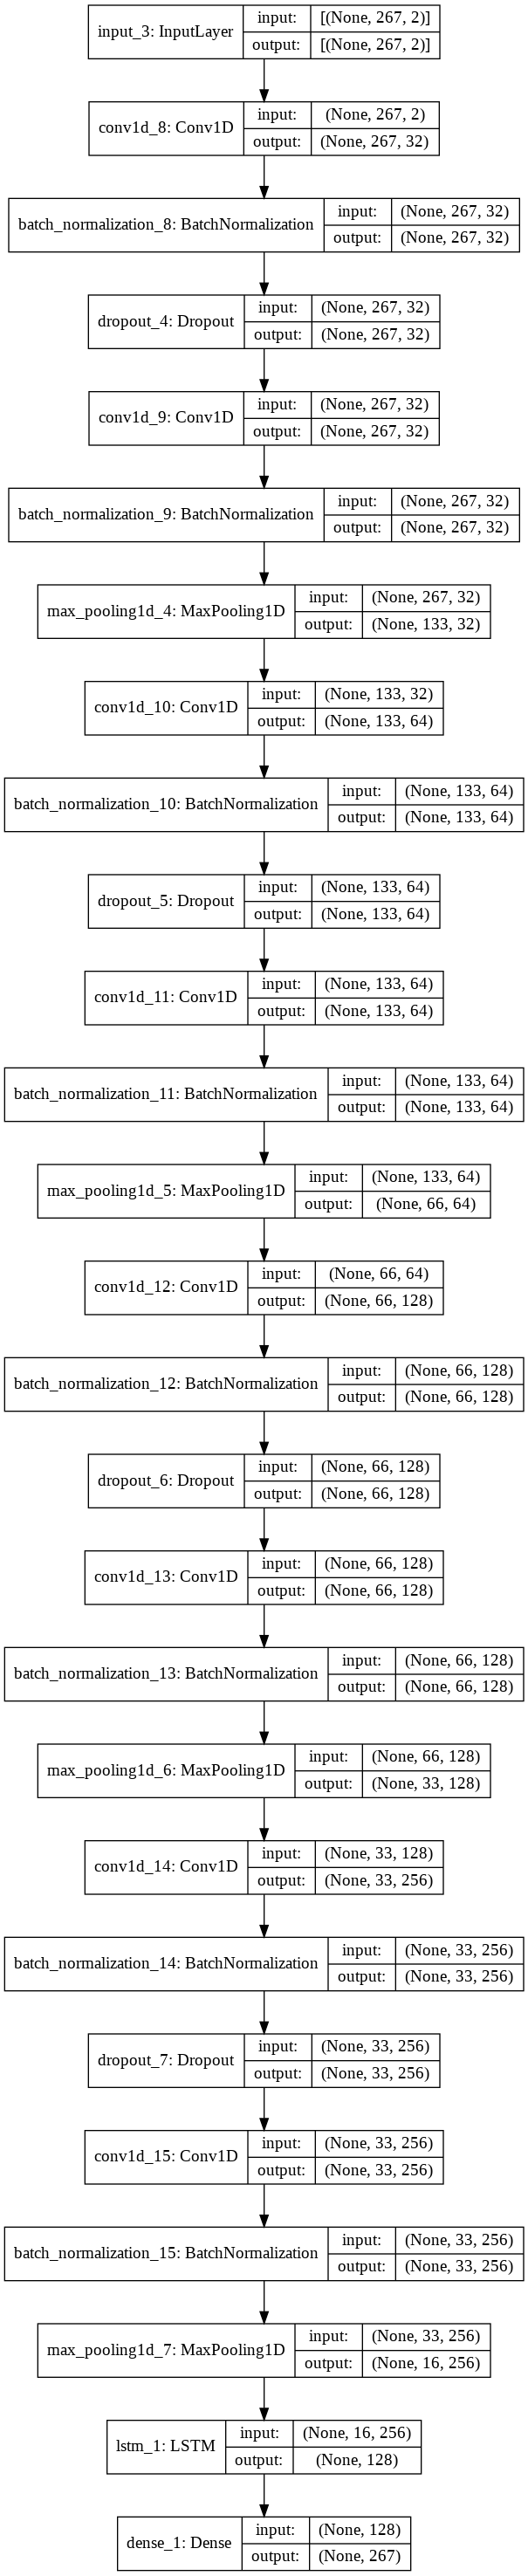

In [20]:
tf.keras.utils.plot_model(model, to_file='/content/model.png', show_shapes=True)


### Metrics

In [21]:
precision =tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

In [22]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())    
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    
    return 1 - K.mean(f1)

### Compile

In [23]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_f1', factor=0.2, patience=15, min_lr=0.001)

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0, nesterov=False)
loss = tf.keras.losses.BinaryCrossentropy()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', patience=15, mode='max', restore_best_weights=True, verbose=1)
model.compile(loss=loss, optimizer=optimizer, metrics=['acc', precision, recall, f1])
#model.compile(loss=loss, optimizer=optimizer, metrics=[Precision, Recall, F1Score])

### Train

In [25]:
history = model.fit(x=X_train, y=Y_train, validation_data=(X_valid, Y_valid), epochs=200, batch_size=32, callbacks=[early_stop])
#history = model.fit(x=[X_train,X_train_mask], y=Y_train, validation_data= ([X_valid,X_valid_mask] ,Y_valid), epochs=200, batch_size=32, callbacks=[early_stop])

Epoch 1/200
13/13 [==============================] - 8s 245ms/step - loss: 0.6369 - acc: 0.2126 - precision_1: 0.3181 - recall_1: 0.4899 - f1: 0.1690 - val_loss: 0.7436 - val_acc: 0.0000e+00 - val_precision_1: 0.1328 - val_recall_1: 0.4597 - val_f1: 0.1198
Epoch 2/200
13/13 [==============================] - 2s 172ms/step - loss: 0.5211 - acc: 0.9758 - precision_1: 0.4737 - recall_1: 0.5034 - f1: 0.1490 - val_loss: 0.7484 - val_acc: 0.0000e+00 - val_precision_1: 0.1211 - val_recall_1: 0.5023 - val_f1: 0.1354
Epoch 3/200
13/13 [==============================] - 2s 177ms/step - loss: 0.4304 - acc: 0.9903 - precision_1: 0.5537 - recall_1: 0.5395 - f1: 0.1443 - val_loss: 0.6674 - val_acc: 0.0000e+00 - val_precision_1: 0.3014 - val_recall_1: 0.5087 - val_f1: 0.1428
Epoch 4/200
13/13 [==============================] - 2s 170ms/step - loss: 0.3816 - acc: 0.9928 - precision_1: 0.5749 - recall_1: 0.5384 - f1: 0.1438 - val_loss: 0.4229 - val_acc: 1.0000 - val_precision_1: 0.5804 - val_recall_1: 

In [26]:
model.evaluate(X_test,Y_test)
#model.evaluate([X_test,X_test_mask],Y_test)

2/2 [==============================] - 0s 15ms/step - loss: 0.3247 - acc: 0.8750 - precision_1: 0.5462 - recall_1: 0.8672 - f1: 0.4419


[0.3247433304786682,
 0.875,
 0.5462258458137512,
 0.8671621084213257,
 0.44186753034591675]

dict_keys(['loss', 'acc', 'precision_1', 'recall_1', 'f1', 'val_loss', 'val_acc', 'val_precision_1', 'val_recall_1', 'val_f1'])


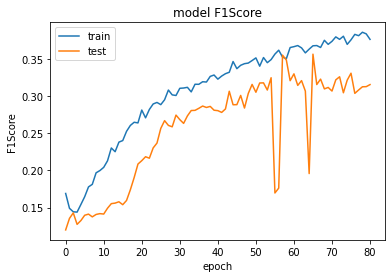

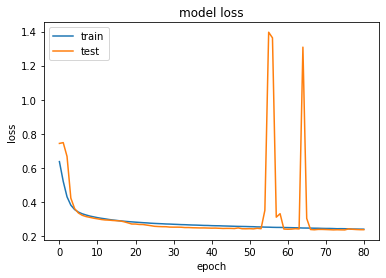

In [27]:
print(history.history.keys())
# summarize history for F1Score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model F1Score')
plt.ylabel('F1Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

###Evaluate with test sample

In [28]:
pred = model.predict(X_test)
#pred = model.predict([X_test,X_test_mask])

In [29]:
pred = np.round(pred)

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [31]:
matrix = confusion_matrix(Y_test.flatten(), pred.flatten(), labels=[0,1])
print('Confusion matrix : \n',matrix)
print(classification_report(Y_test.flatten(), pred.flatten(), labels=[0,1]))

Confusion matrix : 
 [[6976 1551]
 [ 286 1867]]
              precision    recall  f1-score   support

           0       0.96      0.82      0.88      8527
           1       0.55      0.87      0.67      2153

    accuracy                           0.83     10680
   macro avg       0.75      0.84      0.78     10680
weighted avg       0.88      0.83      0.84     10680



###Confusion Matrix (excluding padding)

In [32]:
prediction = list()
for i in range(len(y_test)):
  length = y_test[i].shape[0]
  individual_pred = pred[i][:length]
  individual_pred = list(individual_pred)
  prediction.extend(individual_pred)

In [33]:
truth = list()
for i in range(len(y_test)):
  length = y_test[i].shape[0]
  individual_truth = Y_test[i][:length]
  individual_truth = list(individual_truth)
  truth.extend(individual_truth)

In [34]:
matrix = confusion_matrix(truth, prediction, labels=[0,1])
print('Confusion matrix : \n',matrix)
print(classification_report(truth, prediction, labels=[0,1]))

Confusion matrix : 
 [[ 335 1316]
 [ 286 1867]]
              precision    recall  f1-score   support

           0       0.54      0.20      0.29      1651
           1       0.59      0.87      0.70      2153

    accuracy                           0.58      3804
   macro avg       0.56      0.54      0.50      3804
weighted avg       0.57      0.58      0.52      3804



###Examine single test sample

In [35]:
Y_predict= model.predict([np.expand_dims(X_test[0],axis=0)])
#Y_predict= model.predict([np.expand_dims(X_test[1],axis=0),np.expand_dims(X_test_mask[1],axis=0)])

In [36]:
Y_predict = np.round(Y_predict)

In [37]:
Y_predict

array([[1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
        0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
Y_test[0]

array([1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.